# OV5640和HDMI的人脸检测算法

## Step 1：初始化Overlay以下载bitstream

In [1]:
from pynq.overlays.base import BaseOverlay
from pynq.lib.ov5640 import OV5640
from pynq.lib.iic import *
from pynq.lib.video import *

base = BaseOverlay("base.bit")
camera_in = base.video.camera_in
hdmi_out  = base.video.hdmi_out

## Step 2：实例化I2C以配置OV5640 Camera

In [2]:
iic = AxiIIC(base.ip_dict['cam_iic'])
# OV5640器件地址
address = 0x3c  
ov5640= OV5640(address, iic)

### 初始化OV5640

In [3]:
ov5640.init()

## Step 3: 配置camera_in与hdmi_out 并驱动显示

In [4]:
# monitor configuration: 640*480 @ 60Hz
Mode = VideoMode(640,480,24)
camera_in.configure(Mode, PIXEL_RGB)
hdmi_out.configure(camera_in.mode, PIXEL_RGB)

camera_in.start()
hdmi_out.start()

camera_in.tie(hdmi_out)

## step 4  捕获并显示一帧图片, 大约需要3~5秒

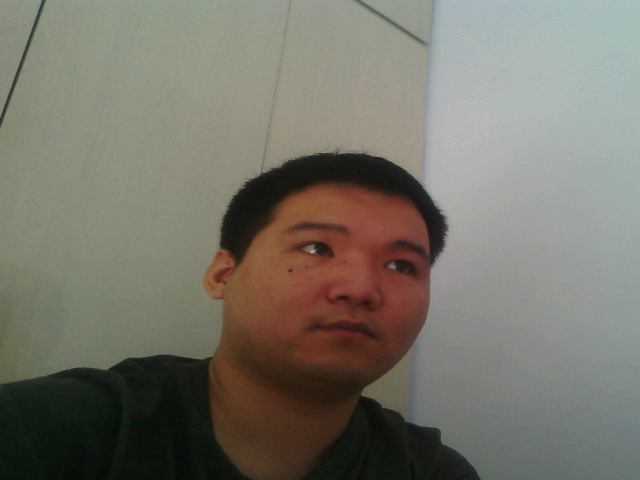

In [5]:
import PIL.Image
frame = camera_in.readframe()
img = PIL.Image.fromarray(frame)
img.save("/home/xilinx/jupyter_notebooks/ov5640_hdmi_7020/HDMI.jpg")

img

### 重新捕获一帧图像

In [30]:
frame = camera_in.readframe()

## step 5 设置检测算法（此处可更换）

In [6]:
import cv2
import numpy as np

face_cascade = cv2.CascadeClassifier(
    '/home/xilinx/jupyter_notebooks/ov5640_hdmi_7020/'
    'haar_default.xml')
eye_cascade = cv2.CascadeClassifier(
    '/home/xilinx/jupyter_notebooks/ov5640_hdmi_7020/'
    'haar_eye.xml')

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.2, 5)

for (x,y,w,h) in faces:
    cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]

    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

### 显示在HDMI显示屏

In [7]:
hdmi_out.writeframe(frame)

### 显示在Notebook中

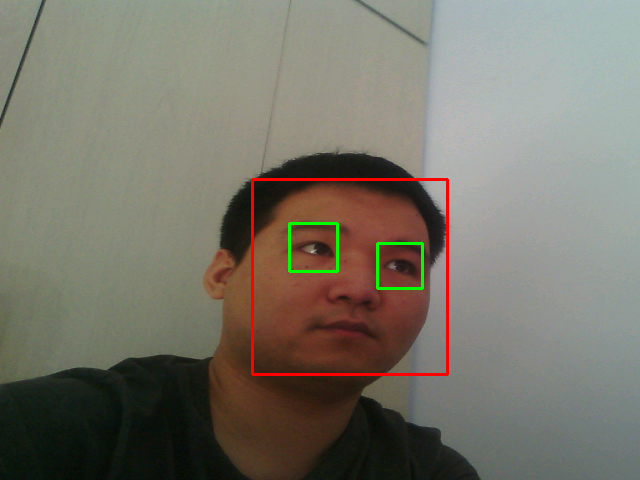

In [8]:
img = PIL.Image.fromarray(frame)
img.save("/home/xilinx/jupyter_notebooks/ov5640_hdmi_7020/HDMI.jpg")

img

# 结束
释放camera_in和hdmi_out

In [9]:
hdmi_out.stop()
camera_in.stop()
del camera_in, hdmi_out